# Code Clause: Fake News Detection 
Raghav Agarwal  
D.J. Sanghvi

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [56]:
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim import corpora, models
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
'''
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
'''

"\nnltk.download('punkt')\nnltk.download('stopwords')\nnltk.download('wordnet')\n"

# Exploratory Data Analysis

## Data Understanding

In [3]:
df = pd.read_csv(r"C:\Users\abhay\OneDrive\Documents\CodeClause Internship\Datasets\Fake News\WELFake_Dataset.csv")
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [5]:
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [6]:
df.dropna(subset=['title', 'text'], how='any', inplace=True)
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


## Visualizing the distribution of labels

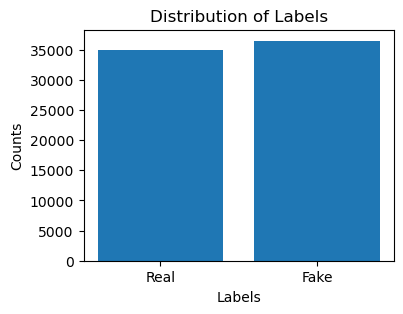

In [7]:
label_counts = df['label'].value_counts()
plt.figure(figsize=(4, 3))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Labels')
plt.xticks([0, 1], ['Real', 'Fake']);

## Computing text lengths for 'title' and 'text' columns

In [8]:
df['title_length'] = df['title'].str.split().str.len()
df['text_length'] = df['text'].str.split().str.len()

### Visualizing text length distributions

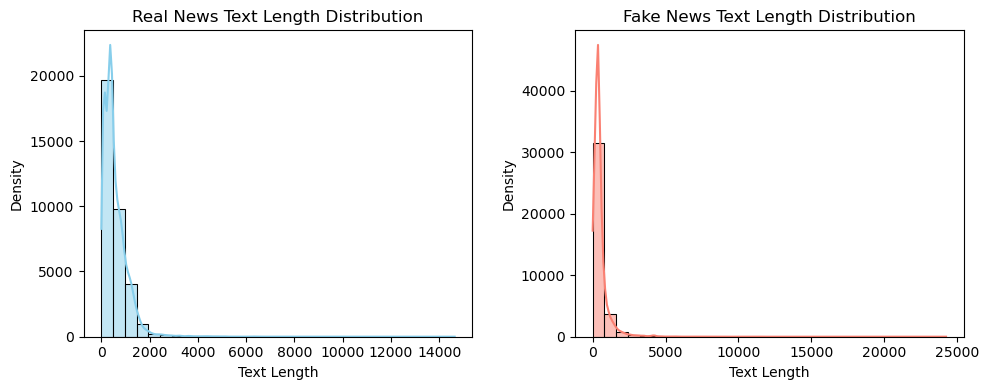

In [9]:
plt.figure(figsize=(10, 4))

real_lengths = df[df['label'] == 0]['text_length']
fake_lengths = df[df['label'] == 1]['text_length']

plt.subplot(1, 2, 1)
sns.histplot(real_lengths, color='skyblue', bins=30, kde=True)
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.title('Real News Text Length Distribution')

plt.subplot(1, 2, 2)
sns.histplot(fake_lengths, color='salmon', bins=30, kde=True)
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.title('Fake News Text Length Distribution')

plt.tight_layout()

## Text Cleaning and Tokenization

In [11]:
lemmatizer = WordNetLemmatizer()

In [12]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub("[^a-zA-Z]", " ", str(text)).lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize tokens
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return clean_tokens

In [13]:
df['clean_title'] = df['title'].apply(clean_text)

In [14]:
df['clean_text'] = df['text'].apply(clean_text)

## Word Frequency Analysis

In [21]:
# Function to flatten list of lists into a single list
flatten = lambda l: [item for sublist in l for item in sublist]

all_title_words = flatten(df['clean_title'].tolist())
all_text_words = flatten(df['clean_text'].tolist())

title_word_freq = Counter(all_title_words)
text_word_freq = Counter(all_text_words)

In [22]:
print("Most common words in titles:")
print(title_word_freq.most_common(10))

Most common words in titles:
[('trump', 19818), ('video', 9283), ('new', 9180), ('u', 7357), ('time', 7269), ('york', 6621), ('say', 4784), ('hillary', 4244), ('obama', 4206), ('clinton', 3876)]


In [23]:
print("\nMost common words in text content:")
print(text_word_freq.most_common(10))


Most common words in text content:
[('said', 234232), ('trump', 214645), ('u', 118315), ('state', 114942), ('would', 105509), ('president', 92521), ('one', 92143), ('people', 91031), ('year', 85239), ('mr', 78674)]


## Word Cloud Visualization

In [24]:
title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(title_word_freq)

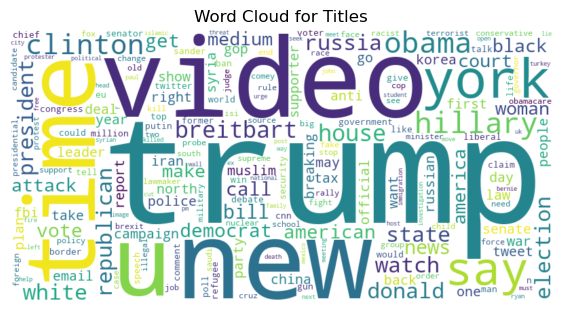

In [26]:
plt.figure(figsize=(7, 4))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Titles');

## Sentiment Analysis

In [28]:
sia = SentimentIntensityAnalyzer()

In [31]:
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

def join_tokens(tokens):
    return ' '.join(tokens)

In [32]:
df['sentiment_score_text'] = df['clean_text'].apply(join_tokens).apply(get_sentiment_score)

In [33]:
df['sentiment_score_title'] = df['clean_title'].apply(join_tokens).apply(get_sentiment_score)

In [34]:
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [35]:
df['sentiment_label_text'] = df['sentiment_score_text'].apply(categorize_sentiment)

In [36]:
df['sentiment_label_title'] = df['sentiment_score_title'].apply(categorize_sentiment)

In [37]:
print("Sentiment analysis for text content:")
print(df[['clean_text', 'sentiment_score_text', 'sentiment_label_text']].head())

Sentiment analysis for text content:
                                          clean_text  sentiment_score_text  \
0  [comment, expected, barack, obama, member, fyf...               -0.9883   
2  [demonstrator, gathered, last, night, exercisi...                0.7351   
3  [dozen, politically, active, pastor, came, pri...                0.9989   
4  [r, sarmat, missile, dubbed, satan, replace, s...               -0.9545   
5  [say, one, time, someone, sued, southern, pove...               -0.9153   

  sentiment_label_text  
0             Negative  
2             Positive  
3             Positive  
4             Negative  
5             Negative  


In [38]:
print("\nSentiment analysis for titles:")
print(df[['clean_title', 'sentiment_score_title', 'sentiment_label_title']].head())


Sentiment analysis for titles:
                                         clean_title  sentiment_score_title  \
0  [law, enforcement, high, alert, following, thr...                -0.7845   
2  [unbelievable, obama, attorney, general, say, ...                 0.6124   
3  [bobby, jindal, raised, hindu, us, story, chri...                 0.4767   
4  [satan, russia, unvelis, image, terrifying, ne...                -0.5719   
5  [time, christian, group, sue, amazon, splc, de...                -0.4588   

  sentiment_label_title  
0              Negative  
2              Positive  
3              Positive  
4              Negative  
5              Negative  


## Topic Modeling

In [40]:
dictionary = corpora.Dictionary(df['clean_text'])
corpus = [dictionary.doc2bow(text) for text in df['clean_text']]  # Converting to bag-of-words corpus

In [41]:
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [42]:
print("Discovered Topics:")
pprint(lda_model.print_topics())

Discovered Topics:
[(0,
  '0.022*"said" + 0.009*"state" + 0.008*"court" + 0.007*"law" + '
  '0.007*"government" + 0.006*"police" + 0.006*"year" + 0.005*"would" + '
  '0.005*"right" + 0.005*"case"'),
 (1,
  '0.035*"trump" + 0.013*"clinton" + 0.010*"president" + 0.010*"said" + '
  '0.009*"republican" + 0.007*"campaign" + 0.007*"election" + 0.007*"donald" + '
  '0.006*"hillary" + 0.006*"mr"'),
 (2,
  '0.018*"u" + 0.015*"said" + 0.011*"state" + 0.007*"military" + '
  '0.007*"united" + 0.007*"war" + 0.007*"russia" + 0.006*"syria" + '
  '0.006*"china" + 0.005*"force"'),
 (3,
  '0.007*"people" + 0.007*"one" + 0.005*"like" + 0.005*"time" + 0.004*"said" + '
  '0.004*"year" + 0.004*"mr" + 0.004*"woman" + 0.003*"life" + 0.003*"even"'),
 (4,
  '0.011*"said" + 0.008*"would" + 0.007*"year" + 0.007*"state" + 0.006*"u" + '
  '0.006*"tax" + 0.006*"company" + 0.005*"percent" + 0.005*"million" + '
  '0.005*"new"')]


## Final Preprocessed Dataset

In [63]:
df.head(3)

,title,text,label,title_length,text_length,clean_title,clean_text,sentiment_score_text,sentiment_score_title,sentiment_label_text,sentiment_label_title
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,18,871,"[law, enforcement, high, alert, following, thr...","[comment, expected, barack, obama, member, fyf...",-0.9883,-0.7845,Negative,Negative
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,18,34,"[unbelievable, obama, attorney, general, say, ...","[demonstrator, gathered, last, night, exercisi...",0.7351,0.6124,Positive,Positive
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,16,1321,"[bobby, jindal, raised, hindu, us, story, chri...","[dozen, politically, active, pastor, came, pri...",0.9989,0.4767,Positive,Positive


# Feature Extraction

## Term Frequency-Inverse Document Frequency

In [52]:
text_data = [' '.join(tokens) for tokens in df['clean_text']]

In [53]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

In [54]:
feature_names = tfidf_vectorizer.get_feature_names_out()

In [58]:
sparse_tfidf = csr_matrix(tfidf_matrix)
sparse_df = pd.DataFrame.sparse.from_spmatrix(sparse_tfidf, columns=feature_names)

# Model Building

## Splitting the data

In [62]:
X = sparse_df  
y = df['label']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [65]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Logistic Regression

In [71]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Model Evaluation

## Random Forest

In [72]:
y_pred_rf = rf_classifier.predict(X_test)

In [73]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of the Random Forest Classifier: {accuracy_rf}")

Accuracy of the Random Forest Classifier: 0.9338132513279285


In [74]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7081
           1       0.93      0.95      0.94      7227

    accuracy                           0.93     14308
   macro avg       0.93      0.93      0.93     14308
weighted avg       0.93      0.93      0.93     14308



In [75]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Confusion Matrix:
[[6528  553]
 [ 394 6833]]


## Logistic Regression

In [76]:
y_pred_lr = logreg.predict(X_test)

In [77]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy of the Logistic Regression Classifier: {accuracy_lr}")

Accuracy of the Logistic Regression Classifier: 0.9448560246016214


In [78]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7081
           1       0.94      0.96      0.95      7227

    accuracy                           0.94     14308
   macro avg       0.95      0.94      0.94     14308
weighted avg       0.95      0.94      0.94     14308



In [79]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Confusion Matrix:
[[6609  472]
 [ 317 6910]]


## Comparing the Models

In [80]:
data = {
    'Models': ['Random Forest', 'Logistic Regression'],
    'Accuracies': [accuracy_rf, accuracy_lr]
}

accuracy_df = pd.DataFrame(data)

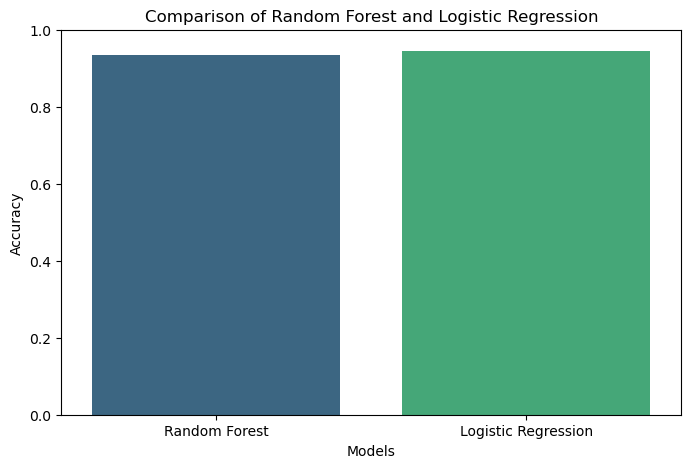

In [81]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Models', y='Accuracies', data=accuracy_df, palette='viridis')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Random Forest and Logistic Regression')
plt.ylim(0.0, 1.0);

Our Logistic Regression model works better with a slightly higher accuracy than the Random Forest model.